## Joe
Want to test runtime and understand differences between dlotko algorithm and my own. 

# What My Code in ECCwithVRApp does
Builds the whole VR complex as a simplex tree with Gudhi. Then computes persistence diagram and ECC by counting simplices by dimension as filtration grows.

# What Dlotko Algorithms 1-2 do
Compute the ECC with "local contributions" without building the full global simplex. Outputs a list C of pairs (filtration value of simplex, (-1)^dim(simplex)). Which is the equivalent to 

$$\chi(t) = \sum_{\sigma: f(\sigma) \leq t}^{} (-1)^{dim(\sigma)}$$ 

Instead of building the full VR complex globally Dlotko loops over each point $x_i$ and builds a local graph $G_i$ on "subsequent neighbors" (neighbors with index > i, so you don't double count). It starts from the 0-simplex $[x_i]$ and then grows simplices by adding vertices from a common neighbor set.

### common_subseq_neighs
If $\sigma$ is a simplex, then a vertex $n$ can extend it to $\sigma \cup \{ n \}$ only if $n$ is adjacent to every vertex in $\sigma$ in the local graph.

### increase_dimension
Takes current simplices and (k simplices) and produces (k+1) simplices. For each simplex $\sigma$ and allowable new vertex $n$, it makes a new simplex $\sigma + [n]$ and performs a filtration on the new simplex. filtration(new simplex) = max(filtration($\sigma$),logest edge from $n$ to vertices of $\sigma$). I.e. a simplex appears when all its edges are present (when radius $\geq$ the maximum edge length in that simplex) 


# Point Cloud 

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import random

point_cloud = []

n_points = 100

random.seed(42)
for i in range(n_points):
    angle = random.uniform(0, 2 * np.pi)
    point_cloud.append([np.cos(angle), np.sin(angle)])

point_cloud = np.array(point_cloud)

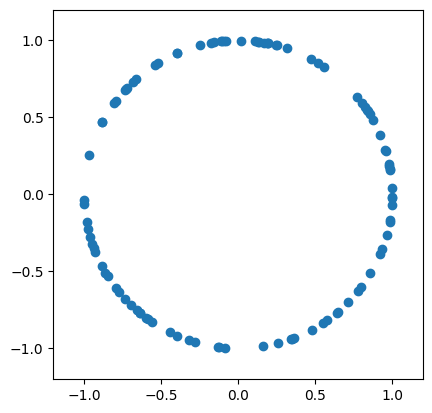

In [9]:
plt.figure()
plt.axis("scaled")
plt.xlim((-1.2, 1.2))
plt.ylim((-1.2, 1.2))
plt.scatter(point_cloud[:, 0], point_cloud[:, 1])
plt.show()

# Functions with Dlotko Algorithm

In [10]:
import numpy as np

# Helper Functions

def pairwise_dist(X: np.ndarray) -> np.ndarray:
    diff = X[:, None, :] - X[None, :, :]
    return np.linalg.norm(diff, axis=2)

def subseq_neighbors(D: np.ndarray, i: int, epsilon: float) -> list[int]:
    # subsequent neighbors of vertex i in the epsilon-graph:
    # return all j > i with D[i, j] <= epsilon
    n = D.shape[0]
    js = np.where((D[i] <= epsilon) & (np.arange(n) > i))[0]
    return js.tolist()

def local_graph_subseq_neighbors(D: np.ndarray, i: int, epsilon: float) -> list[int]:
    """
    create local graph Gi of subsequent neighbors of xi
    We don't need to store Gi though, only subseq_neighbors(Gi, xi) for alg 1
    """
    return subseq_neighbors(D, i, epsilon)


# Algorithm 2

def inc_dim(D: np.ndarray,
            simplices: list[list[int]],
            filtrations: list[float],
            common_subseq_neighs: list[list[int]],
            epsilon: float) -> tuple[list[list[int]], list[float], list[list[int]]]:
    """
    input: local graph Gi (implicit from D + epsilon), simplices, common_subseq_neighs
    output: updated simplices, filtrations, common subseq neighs
    """
    new_simps = []
    new_filtrations = []
    new_common_subseq_neighs = []

    for sigma, f_sigma, commonN in zip(simplices, filtrations, common_subseq_neighs):
        # for every n in common_subseq_neighs[sigma] do
        for n in commonN:
            sigma2 = sigma + [n]
            new_simps.append(sigma2)

            # consider all edges from vertices of sigma to n and take longest one
            longest_edge = 0.0
            for v in sigma:
                d = D[v, n]
                if d > longest_edge:
                    longest_edge = d

            # filtration(sigma ∪ {n}) = max(filtration(sigma), longest edge)
            new_f = max(f_sigma, longest_edge)
            new_filtrations.append(new_f)

            # intersect common subseq neighs with subseq neighbors of n
            neigh_n = subseq_neighbors(D, n, epsilon)
            intersection = sorted(set(commonN).intersection(neigh_n))
            new_common_subseq_neighs.append(intersection)

    return new_simps, new_filtrations, new_common_subseq_neighs


# Algorithm 1

def compute_loc_contributions_vr(
        point_cloud: np.ndarray,
        epsilon: float,
        max_dim: int | None = None
    ) -> list[tuple[float, int]]:
    """
    input: ordered point cloud X, epsilon > 0
    output: ordered list of pairs (filtration, +-1)
    """
    X = np.asarray(point_cloud, dtype=float)
    n = X.shape[0]
    D = pairwise_dist(X)

    # Create empty vector C
    C = []

    # for every xi in X do
    for i in range(n):
        # simplices = [[xi]]
        simplices = [[i]]

        # filtrations = [0]
        filtrations = [0.0]

        # common_subseq_neighs = [[subseq_neighbors(Gi, xi)]]
        common_subseq_neighs = [local_graph_subseq_neighbors(D, i, epsilon)]

        # while simplices not empty do
        while len(simplices) > 0:
            # for every simplex sigma in simplices do
            for sigma, f_sigma in zip(simplices, filtrations):
                dim_sigma = len(sigma) - 1
                sign = 1 if (dim_sigma % 2 == 0) else -1
                C.append((f_sigma, sign))

            # stop at max_dim (practical guard)
            if max_dim is not None:
                cur_dim = len(simplices[0]) - 1
                if cur_dim >= max_dim:
                    break

            # INCREASE_DIMENSION(...)
            simplices, filtrations, common_subseq_neighs = inc_dim(
                D, simplices, filtrations, common_subseq_neighs, epsilon
            )

    # sort C according to filtration value
    C.sort(key=lambda t: t[0])
    return C

# ECC

In [11]:
#ECC from alg 1 and 2

import matplotlib.pyplot as plt
def ecc_from_contributions(C, grid):
    f = np.array([x[0] for x in C], dtype = float)
    s = np.array([x[1] for x in C], dtype = int)

    grid = np.asarray(grid, dtype = float)
    idx = np.searchsorted(f, grid, side = "right")
    cs = np.concatenate([[0], np.cumsum(s)])
    chi = cs[idx]
    return chi

def plot_ecc(point_cloud, epsilon, max_simplex_dim = 3, num_grid = 300):
    #computes C via alg 1 and 2 and plots ECC

    C = compute_loc_contributions_vr(point_cloud, epsilon=epsilon, max_dim=max_simplex_dim)

    grid = np.linspace(0, epsilon, num_grid)
    chi = ecc_from_contributions(C, grid)

    plt.figure()
    plt.plot(grid, chi)
    plt.xlabel("Filtration Value (t)")
    plt.ylabel("Euler Characteristic")
    plt.title(f"ECC (epsilon = {epsilon}, Max Simplex Dim = {max_simplex_dim})")
    plt.show()

    return grid, chi, C




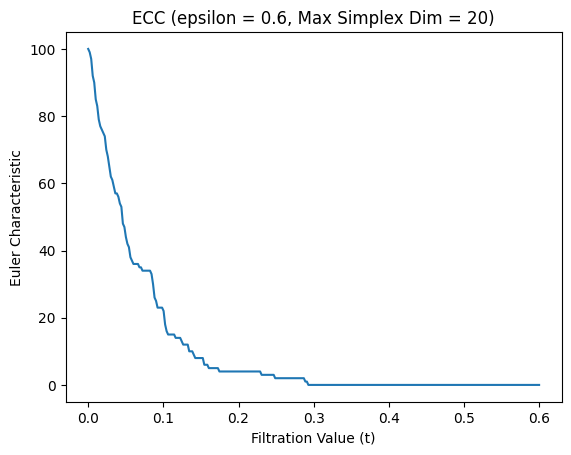

In [17]:
grid, chi, C = plot_ecc(point_cloud, epsilon=0.6, max_simplex_dim=20)

# Runs Much Faster!